Dataset path: /content/mitbih/mit-bih-arrhythmia-database-1.0.0
Train: 28 Test: 19
Processing Train


100%|██████████| 28/28 [00:02<00:00, 11.24it/s]


Processing Test


100%|██████████| 19/19 [00:01<00:00, 15.15it/s]


Epoch 1 Train Acc 0.7481
Epoch 2 Train Acc 0.8758
Epoch 3 Train Acc 0.9037
Epoch 4 Train Acc 0.9184
Epoch 5 Train Acc 0.9281
Epoch 6 Train Acc 0.9334
Epoch 7 Train Acc 0.9440
Epoch 8 Train Acc 0.9495
Epoch 9 Train Acc 0.9549
Epoch 10 Train Acc 0.9572
Epoch 11 Train Acc 0.9614
Epoch 12 Train Acc 0.9645
Epoch 13 Train Acc 0.9689
Epoch 14 Train Acc 0.9705
Epoch 15 Train Acc 0.9685
Epoch 16 Train Acc 0.9744
Epoch 17 Train Acc 0.9752
Epoch 18 Train Acc 0.9744
Epoch 19 Train Acc 0.9776
Epoch 20 Train Acc 0.9776
Epoch 21 Train Acc 0.9812
Epoch 22 Train Acc 0.9803
Epoch 23 Train Acc 0.9821
Epoch 24 Train Acc 0.9808
Epoch 25 Train Acc 0.9855

Classification Report

              precision    recall  f1-score   support

           N       0.82      0.62      0.71     31964
           S       0.06      0.06      0.06      1777
           V       0.72      0.83      0.77      2458
           F       0.02      0.55      0.04       390
           Q       0.80      0.59      0.68      7445

    accur

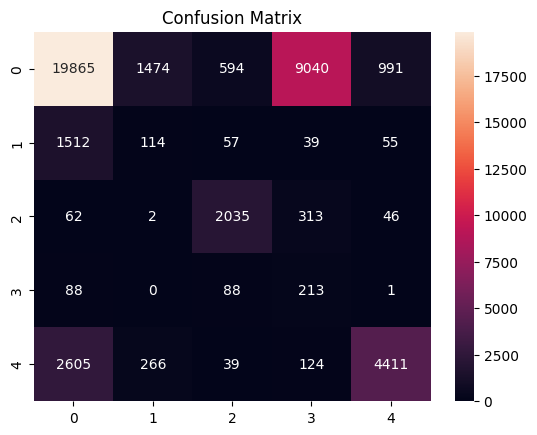

Macro AUROC: 0.7561922631560322
Saved Heart-model.pt


In [8]:
# ==========================================================
# HEART ARRHYTHMIA FINAL MODERN MODEL (MULTI-SCALE ATTENTION CNN)
# ==========================================================

!pip -q install wfdb seaborn scikit-learn matplotlib

import os, zipfile, wfdb, numpy as np, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from scipy.signal import butter, filtfilt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

# -----------------------
# UNZIP DATASET
# -----------------------
ZIP_PATH="/content/mit-bih-arrhythmia-database-1.0.0.zip"
ROOT="/content/mitbih"

if not os.path.exists(ROOT):
    with zipfile.ZipFile(ZIP_PATH,'r') as z:z.extractall(ROOT)

for f in os.listdir(ROOT):
    if "mit-bih" in f.lower():
        DATA_DIR=os.path.join(ROOT,f)

print("Dataset path:",DATA_DIR)

with open(os.path.join(DATA_DIR,"RECORDS")) as f:
    ALL=[r.strip() for r in f.readlines()]

TRAIN=['100','101','103','105','106','108','109','111','112','113','115','116','118','119','121','122','124','200','201','203','205','207','208','209','215','220','223','230']
TEST=['102','104','107','110','114','117','123','202','210','212','213','214','219','221','222','228','231','232','233','234']

TRAIN=[r for r in TRAIN if r in ALL]
TEST=[r for r in TEST if r in ALL]

print("Train:",len(TRAIN),"Test:",len(TEST))

# -----------------------
# SIGNAL PROCESSING
# -----------------------
def bandpass(sig,low=0.5,high=40,fs=360,order=4):
    nyq=0.5*fs
    b,a=butter(order,[low/nyq,high/nyq],btype='band')
    return filtfilt(b,a,sig)

WL=int(0.3*360); WR=int(0.4*360)

AAMI={'N':'N','L':'N','R':'N','e':'N','j':'N','A':'S','a':'S','J':'S','S':'S','V':'V','E':'V','F':'F','/':'Q','f':'Q','Q':'Q'}

def process(pid):
    try:
        rec=wfdb.rdrecord(os.path.join(DATA_DIR,pid))
        ann=wfdb.rdann(os.path.join(DATA_DIR,pid),'atr')
    except:
        return [],[]

    sig=bandpass(rec.p_signal[:,0])

    X,y=[],[]
    for r,s in zip(ann.sample,ann.symbol):
        if r-WL<0 or r+WR>=len(sig):continue
        X.append(sig[r-WL:r+WR])
        y.append(AAMI.get(s,'Q'))
    return X,y

def build(patients):
    X,y=[],[]
    for p in tqdm(patients):
        a,b=process(p);X+=a;y+=b
    return np.array(X),np.array(y)

print("Processing Train")
X_train,y_train=build(TRAIN)
print("Processing Test")
X_test,y_test=build(TEST)

label_map={'N':0,'S':1,'V':2,'F':3,'Q':4}
y_train=np.array([label_map[i] for i in y_train])
y_test=np.array([label_map[i] for i in y_test])

# -----------------------
# DATASET
# -----------------------
class ECGDataset(Dataset):
    def __init__(self,X,y):
        self.X=torch.tensor(X,dtype=torch.float32).unsqueeze(1)
        self.y=torch.tensor(y,dtype=torch.long)
    def __len__(self):return len(self.X)
    def __getitem__(self,i):return self.X[i],self.y[i]

class_counts=np.bincount(y_train)
weights=1./class_counts
sample_weights=weights[y_train]
sampler=WeightedRandomSampler(sample_weights,len(sample_weights),replacement=True)

train_loader=DataLoader(ECGDataset(X_train,y_train),256,sampler=sampler)
test_loader=DataLoader(ECGDataset(X_test,y_test),256)

# -----------------------
# ATTENTION MODEL
# -----------------------
class ChannelAttention(nn.Module):
    def __init__(self,channels,r=8):
        super().__init__()
        self.avg=nn.AdaptiveAvgPool1d(1)
        self.fc=nn.Sequential(
            nn.Linear(channels,channels//r),
            nn.ReLU(),
            nn.Linear(channels//r,channels),
            nn.Sigmoid()
        )
    def forward(self,x):
        b,c,t=x.size()
        y=self.avg(x).view(b,c)
        y=self.fc(y).view(b,c,1)
        return x*y

class MultiScaleBlock(nn.Module):
    def __init__(self,in_ch,out_ch):
        super().__init__()
        self.conv3=nn.Conv1d(in_ch,out_ch,3,padding=1)
        self.conv5=nn.Conv1d(in_ch,out_ch,5,padding=2)
        self.conv7=nn.Conv1d(in_ch,out_ch,7,padding=3)
        self.bn=nn.BatchNorm1d(out_ch*3)
        self.att=ChannelAttention(out_ch*3)
    def forward(self,x):
        x=torch.cat([self.conv3(x),self.conv5(x),self.conv7(x)],dim=1)
        x=F.relu(self.bn(x))
        return self.att(x)

class ECGNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1=MultiScaleBlock(1,32)
        self.pool1=nn.MaxPool1d(2)
        self.block2=MultiScaleBlock(96,64)
        self.pool2=nn.MaxPool1d(2)
        self.block3=MultiScaleBlock(192,128)
        self.gap=nn.AdaptiveAvgPool1d(1)
        self.fc=nn.Linear(384,5)
    def forward(self,x):
        x=self.pool1(self.block1(x))
        x=self.pool2(self.block2(x))
        x=self.block3(x)
        x=self.gap(x).squeeze(-1)
        return self.fc(x)

device="cuda" if torch.cuda.is_available() else "cpu"
model=ECGNet().to(device)

# -----------------------
# FOCAL LOSS
# -----------------------
class FocalLoss(nn.Module):
    def __init__(self,gamma=2):
        super().__init__()
        self.gamma=gamma
        self.ce=nn.CrossEntropyLoss(reduction='none')
    def forward(self,logits,targets):
        ce=self.ce(logits,targets)
        pt=torch.exp(-ce)
        return ((1-pt)**self.gamma*ce).mean()

criterion=FocalLoss().to(device)
opt=torch.optim.AdamW(model.parameters(),lr=3e-4)

# -----------------------
# TRAIN
# -----------------------
for epoch in range(25):
    model.train();total=correct=0
    for x,y in train_loader:
        x,y=x.to(device),y.to(device)
        opt.zero_grad()
        out=model(x)
        loss=criterion(out,y)
        loss.backward();opt.step()
        pred=out.argmax(1)
        correct+=(pred==y).sum().item();total+=len(y)
    print(f"Epoch {epoch+1} Train Acc {correct/total:.4f}")

# -----------------------
# EVALUATION
# -----------------------
model.eval()
preds,probs,true=[],[],[]
with torch.no_grad():
    for x,y in test_loader:
        x=x.to(device)
        out=model(x)
        p=torch.softmax(out,1).cpu().numpy()
        preds.extend(p.argmax(1));probs.extend(p);true.extend(y.numpy())

print("\nClassification Report\n")
print(classification_report(true,preds,target_names=['N','S','V','F','Q']))

cm=confusion_matrix(true,preds)
sns.heatmap(cm,annot=True,fmt='d');plt.title("Confusion Matrix");plt.show()

try:
    print("Macro AUROC:",roc_auc_score(true,probs,multi_class='ovr'))
except:
    print("AUROC skipped")

# -----------------------
# SAVE MODEL
# -----------------------
torch.save(model.state_dict(),"/content/Heart-model.pt")
print("Saved Heart-model.pt")


In [1]:
# ==========================================
# DIABETES RISK MODEL (TABULAR DEEP LEARNING)
# ==========================================

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from torch.utils.data import Dataset, DataLoader

# ---------------------------
# LOAD DATA
# ---------------------------
url="https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

cols=['preg','glucose','bp','skin','insulin','bmi','dpf','age','outcome']
df=pd.read_csv(url,names=cols)

X=df.drop('outcome',axis=1).values
y=df['outcome'].values

scaler=StandardScaler()
X=scaler.fit_transform(X)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

# ---------------------------
# DATASET
# ---------------------------
class DiabetesDataset(Dataset):
    def __init__(self,X,y):
        self.X=torch.tensor(X,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.float32)

    def __len__(self):return len(self.X)
    def __getitem__(self,i):return self.X[i],self.y[i]

train_loader=DataLoader(DiabetesDataset(X_train,y_train),batch_size=32,shuffle=True)
test_loader=DataLoader(DiabetesDataset(X_test,y_test),batch_size=32)

# ---------------------------
# MODEL (Tabular NN)
# ---------------------------
class DiabetesNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net=nn.Sequential(
            nn.Linear(8,32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(32,16),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(16,1)
        )
    def forward(self,x):return self.net(x)

device="cuda" if torch.cuda.is_available() else "cpu"
model=DiabetesNet().to(device)

criterion=nn.BCEWithLogitsLoss()
opt=torch.optim.Adam(model.parameters(),lr=1e-3)

# ---------------------------
# TRAIN
# ---------------------------
for epoch in range(80):
    model.train()
    for x,y in train_loader:
        x,y=x.to(device),y.to(device).unsqueeze(1)
        opt.zero_grad()
        loss=criterion(model(x),y)
        loss.backward()
        opt.step()
    if epoch%10==0:
        print("epoch",epoch)

# ---------------------------
# EVALUATE
# ---------------------------
model.eval()
probs=[];true=[]
with torch.no_grad():
    for x,y in test_loader:
        out=torch.sigmoid(model(x.to(device))).cpu().numpy()
        probs.extend(out)
        true.extend(y.numpy())

pred=(np.array(probs)>0.5).astype(int)

print("\nClassification Report\n")
print(classification_report(true,pred))
print("AUROC:",roc_auc_score(true,probs))

# ---------------------------
# SAVE MODEL
# ---------------------------
torch.save(model.state_dict(),"/content/Diabetes-model.pt")
print("Saved Diabetes-model.pt")


epoch 0
epoch 10
epoch 20
epoch 30
epoch 40
epoch 50
epoch 60
epoch 70

Classification Report

              precision    recall  f1-score   support

         0.0       0.78      0.83      0.80       100
         1.0       0.64      0.56      0.59        54

    accuracy                           0.73       154
   macro avg       0.71      0.69      0.70       154
weighted avg       0.73      0.73      0.73       154

AUROC: 0.817037037037037
Saved Diabetes-model.pt


In [3]:
# ==========================================
# PARKINSON VOICE RISK MODEL
# ==========================================

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from torch.utils.data import Dataset, DataLoader

# ---------------------------
# LOAD DATA
# ---------------------------
url="https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data"
df=pd.read_csv(url)

y=df['status'].values
X=df.drop(['name','status'],axis=1).values

scaler=StandardScaler()
X=scaler.fit_transform(X)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

# ---------------------------
# DATASET
# ---------------------------
class ParkinsonDataset(Dataset):
    def __init__(self,X,y):
        self.X=torch.tensor(X,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.float32)

    def __len__(self):return len(self.X)
    def __getitem__(self,i):return self.X[i],self.y[i]

train_loader=DataLoader(ParkinsonDataset(X_train,y_train),batch_size=16,shuffle=True)
test_loader=DataLoader(ParkinsonDataset(X_test,y_test),batch_size=16)

# ---------------------------
# MODEL
# ---------------------------
class ParkinsonNet(nn.Module):
    def __init__(self,input_dim):
        super().__init__()
        self.net=nn.Sequential(
            nn.Linear(input_dim,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(64,32),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(32,1)
        )
    def forward(self,x):return self.net(x)

device="cuda" if torch.cuda.is_available() else "cpu"
model=ParkinsonNet(X.shape[1]).to(device)

criterion=nn.BCEWithLogitsLoss()
opt=torch.optim.Adam(model.parameters(),lr=1e-3)

# ---------------------------
# TRAIN
# ---------------------------
for epoch in range(120):
    model.train()
    for x,y in train_loader:
        x,y=x.to(device),y.to(device).unsqueeze(1)
        opt.zero_grad()
        loss=criterion(model(x),y)
        loss.backward()
        opt.step()
    if epoch%20==0:
        print("epoch",epoch)

# ---------------------------
# EVALUATE
# ---------------------------
model.eval()
probs=[];true=[]
with torch.no_grad():
    for x,y in test_loader:
        out=torch.sigmoid(model(x.to(device))).cpu().numpy()
        probs.extend(out)
        true.extend(y.numpy())

pred=(np.array(probs)>0.5).astype(int)

print("\nClassification Report\n")
print(classification_report(true,pred))
print("AUROC:",roc_auc_score(true,probs))

# ---------------------------
# SAVE MODEL
# ---------------------------
torch.save(model.state_dict(),"/content/Parkinson-model.pt")
print("Saved Parkinson-model.pt")


epoch 0
epoch 20
epoch 40
epoch 60
epoch 80
epoch 100

Classification Report

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95        10
         1.0       1.00      0.97      0.98        29

    accuracy                           0.97        39
   macro avg       0.95      0.98      0.97        39
weighted avg       0.98      0.97      0.97        39

AUROC: 0.9931034482758622
Saved Parkinson-model.pt
